In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

# Functions

In [2]:
def listkap_matkappa(kappa):
    matkappa = np.zeros((no_states,no_states))
    triangle = np.triu(np.ones((no_states, no_states), dtype=bool), k=1) 
    matkappa[triangle]= kappa
    matkappa += matkappa.T
    return matkappa

def matkappa_matr(kappa):
    matkappa = listkap_matkappa(kappa)
    matr = np.zeros((no_states,no_states)) 
    matr = matkappa * eq_pop[:, np.newaxis] 
    rdiag = -np.sum(matr,0)
    matr = matr + np.diag(rdiag)
    return matr

def p_model(exp_r_del_t, p_zero):
    p_model = np.zeros((time_size,no_states))

    p_model[0,:] = p_zero
    for i in range(1,time_size):
        p_model[i,:] = exp_r_del_t.dot(p_model[i-1,:])
    return p_model

def residual_kappaonly(kappa):
    r_of_t = matkappa_matr(kappa)
    expm_rdelt = expm(r_of_t*del_t)
    p_mod = p_model(expm_rdelt,p_zero)
    residual = (population_data-p_mod).flatten()
    return residual

def residual_p1(p1):
    r_of_t = matkappa_matr(kappa_optimized)
    expm_rdelt = expm(r_of_t*del_t)
    p_mod = p_model(expm_rdelt,p1)
    residual = (population_data-p_mod).flatten()
    return residual

# Data 

In [3]:
column_names = ["Time"]
site_data_path = "../Data/mash_site300K.dat"
for i in range(1,8):
    column_names.append(str(i))
site_df = pd.read_csv(site_data_path, delimiter=" ", names=column_names)
site_df = site_df[(site_df.index % 10 == 0) | (site_df.index == len(site_df.index) - 1)]

t1 = 800
t2 = 1000

# All the values within the df
site_eq = site_df.values 
full_time = site_df["Time"].values

# Only values below t2
site_df = site_df[site_df["Time"]<=t2]
site_values= site_df.values #DF to NP
site_pop = site_values[:,1:]

start_to_t1 = site_values[site_values[:,0]<=t1]
t1_to_t2_full = site_values[site_values[:,0]>=t1]

no_states = 7
eq_pop = site_eq[-1]
eq_pop = eq_pop[1:8]

# Optimization and Residual Calc

In [ ]:
kappa_guess = np.full(21,0.01)
kappa = kappa_guess

#Array of t0 to use
start_to_t1_time = start_to_t1[:,0]
del_t_val = start_to_t1_time[1]-start_to_t1_time[0]

start_time_values = start_to_t1_time[:-10]

t1_to_t2_time = t1_to_t2_full[:,0]
t1_to_t2_pop = t1_to_t2_full[:,1:]

p_zero = start_to_t1[-1]
p_zero = p_zero[1:8]

save_kappas = []
save_resid = []


for index, start_time in enumerate(start_time_values,start=1):
    print(index)
    
    #TRAIN
    t0_to_t1 = start_to_t1[start_to_t1[:,0]>=start_time]
    time_size = len(t0_to_t1)
    t0_to_t1 = t0_to_t1[:,1:]
    population_data = t0_to_t1[::-1]
    del_t = -del_t_val

    least_squares_result = least_squares(residual_kappaonly, kappa, bounds=(0,float("inf")),xtol=None, ftol=1e-8) 

    kappa_optimized = least_squares_result.x
    save_kappas.append(kappa_optimized)
    kappa = kappa_optimized

    #TEST
    population_data = t1_to_t2_full[:,1:]
    time_size = len(t1_to_t2_full)
    del_t = del_t_val

    #RESIDUAL CALC
    resid = residual_kappaonly(kappa_optimized)
    resid = (np.sum(np.abs(resid))**2)/(time_size*7)

    save_resid.append(resid)

save_kappas = np.column_stack((start_time_values,save_kappas))
save_resid = np.column_stack((start_time_values,save_resid))

np.savetxt(f"/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/800_1000_resid5.dat", save_resid, delimiter = "\t")
np.savetxt(f"/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/800_1000_kap_saved5.dat",save_kappas, delimiter = "\t")

Text(0.5, 0, '$t_0$ [fs]')

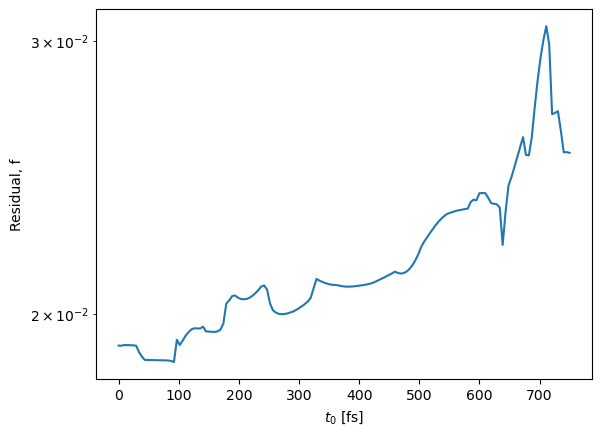

In [5]:
site_residual_data = np.loadtxt("/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/800_1000_resid4.dat")

plt.semilogy(site_residual_data[:,0],site_residual_data[:,1])

plt.ylabel('Residual, f')
plt.xlabel(r'$t_0$ [fs]')

In [6]:
kappas = np.loadtxt("/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/800_1000_kap_saved4.dat")
kappa_450 = kappas[19]
kappa_450 = kappa_450[1:22]


t1_to_t3_time = full_time[full_time[:]>=t1]
time_size = len(t1_to_t3_time)
r_matrix = matkappa_matr(kappa_450) 
expm_rt = expm(r_matrix*del_t_val)
pop_450 = p_model(expm_rt, p_zero)

start_to_t1_time = start_to_t1[:,0]
start_to_t1_size = len(start_to_t1_time)
time_size = start_to_t1_size
expm_rt = expm(r_matrix*-del_t_val)
pop_450_back = p_model(expm_rt, p_zero)
pop_450_back = pop_450_back[::-1]

pop_450_back = np.column_stack((start_to_t1_time,pop_450_back))
pop_450 = np.column_stack((t1_to_t3_time, pop_450))

pop_450 = np.vstack((pop_450_back,pop_450))
np.savetxt("/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/pop_450.dat", pop_450, delimiter = "\t")

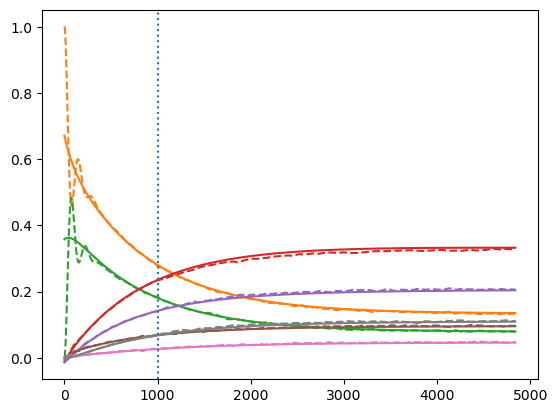

In [7]:
site_data = np.loadtxt(site_data_path)

saved_450 = np.loadtxt("/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/pop_450.dat")

for i, column_name in enumerate(column_names[1:], start=1):
    c = "C%i"%i
    plt.plot(site_data[:,0], site_data[:,i],"--", label=column_name, color=c)
    plt.plot(saved_450[:,0],saved_450[:,i], "-",color=c)

plt.axvline(x=1000, linestyle = ":")
plt.show()

# Friday 3rd November

- Fix Fitting window as between 0 fs and 1000 fs,
- Using Kappas from that fitting window, find the residual error in the region 500 fs and 1000 fs and compare the residual error to that calculated for between 1000 fs and 5000 fs

## Data

In [73]:
column_names = ["Time"]
site_data_path = "../Data/mash_site300K.dat"
for i in range(1,8):
    column_names.append(str(i))
site_df = pd.read_csv(site_data_path, delimiter=" ", names=column_names)
site_df = site_df[(site_df.index % 10 == 0) | (site_df.index == len(site_df.index) - 1)]

# All the values within the df
site_eq = site_df.values 
full_time = site_df["Time"].values

t0 = 0
t1 = 500
t2 = 5000
t3 = full_time[-1]

# Only values below t2
site_df = site_df[site_df["Time"]<=t2]
start_to_t2= site_df.values #DF to NP

#EDIT THIS
start_to_t2 = start_to_t2[start_to_t2[:,0]>=t0]
t1_to_t2_full = start_to_t2[start_to_t2[:,0]>=t1]

no_states = 7
eq_pop = site_eq[-1]
eq_pop = eq_pop[1:8]

In [81]:
kappa_guess = np.full(21,0.01)
kappa = kappa_guess

save_kappas = []
save_resid1 = []
save_resid2 = []

t2s = 80*np.arange(1,51)
# t2s = 40*np.arange(1,2)
t2s = np.array([800])
save_t = []
print(t2s)
f = open("ls_res.dat",'w')
f.close()
for t2 in t2s:
    try:
        t1 = t2/2
        print(t2)
        data = site_df[site_df["Time"]<=t2]
        start_to_t2= data.values #DF to NP
        start_to_t2 = start_to_t2[start_to_t2[:,0]>=t0]
        t1_to_t2_full = start_to_t2[start_to_t2[:,0]>=t1]
        #Array of t0 to use
        start_to_t2_time = start_to_t2[:,0]
        del_t_val = start_to_t2_time[1]-start_to_t2_time[0]

        t1_to_t2_time = t1_to_t2_full[:,0]
        t1_to_t2_pop = t1_to_t2_full[:,1:]

        t0_to_t2_time = start_to_t2[:,0]
        t0_to_t2_pop = start_to_t2[:,1:]

        p_zero = start_to_t2[-1]
        p_zero = p_zero[1:8]

        #TRAIN
        time_size = len(t0_to_t2_time)
        population_data = t0_to_t2_pop[::-1]
        del_t = -del_t_val
        print("train time_size:",time_size)

        least_squares_result = least_squares(residual_kappaonly, kappa, bounds=(0,float("inf")),xtol=None, ftol=1e-8) 
        kappa_optimized = least_squares_result.x
        print(kappa_optimized)
        ls_cost = 2.*np.sqrt(least_squares_result.cost)/(time_size*no_states)
        print("LS loss:",ls_cost)
        
        f = open("ls_res.dat",'a')
        f.write("%20.10f %20.10f\n"%(t2,ls_cost))
        f.close()

        #TEST t0-t2
#         population_data = t0_to_t2_pop
#         time_size = len(population_data)
#         del_t = del_t_val
#         print("t0-t2 length: ",time_size)
#         p_zero = population_data[0,:]
#         print("p_zero eval t0-t2:",p_zero)

        #RESIDUAL CALC
#         resid1 = residual_kappaonly(kappa_optimized)
#         resid1 = np.sqrt(np.sum(resid1**2))/(time_size*no_states)
#         print("Resid 1:",resid1)

        #TEST t1-t2
        population_data = t1_to_t2_full[:,1:]
        time_size = len(t1_to_t2_full)
        del_t = del_t_val
        p_zero = population_data[0,:]
        print("t1-t2 length: ",time_size)

        #RESIDUAL CALC
        resid1 = residual_kappaonly(kappa_optimized)
        resid1 = np.sqrt(np.sum(resid1**2))/(time_size*no_states)
        print("Resid 1:",resid1)

        #TEST ALL
        t2_to_t3_full = site_eq[site_eq[:,0]>=t2]
        t2_to_t3_pop = t2_to_t3_full[:,1:]
        t2_to_t3_time = t2_to_t3_full[:,0]

        population_data = t2_to_t3_pop
        time_size = len(t2_to_t3_time)
        p_zero = population_data[0,:]
        print("t2-t3 length: ",time_size)
        
        r_of_t = matkappa_matr(kappa_optimized)
        expm_rdelt = expm(r_of_t*del_t)
        p_opt = p_model(expm_rdelt, p_zero)
            
        resid2 = residual_kappaonly(kappa_optimized)
        resid2 = np.sqrt(np.sum(resid2**2))/(time_size*no_states)
        print("Resid 2:",resid2)

        save_kappas.append(kappa_optimized)
        save_resid1.append(resid1)
        save_resid2.append(resid2)
        
        save_t.append(t2)
    except Exception as e:
        print("failed for t2=",t2)
        print(e)
        continue

save_t = np.array(save_t)
save_kappas = np.array(save_kappas)
save_kappas = np.column_stack((save_t,save_kappas))
save_resid1 = np.column_stack((save_t,save_resid1))
save_resid2 = np.column_stack((save_t,save_resid2))

np.savetxt(f"scan_0_5000_resid1.dat", save_resid1, delimiter = "\t")
np.savetxt(f"scan_0_5000_resid2.dat", save_resid2, delimiter = "\t")
np.savetxt(f"scan_0_5000_kap_saved.dat",save_kappas, delimiter = "\t")

[800]
800
train time_size: 166
[5.45446036e-02 2.01292724e-03 1.71217997e-03 3.72426799e-03
 1.28387821e-03 8.18498680e-04 6.26493207e-05 9.19478069e-05
 1.62861744e-06 1.26799379e-06 2.97767780e-09 3.97113848e-05
 2.90193915e-07 1.94882516e-05 5.52700872e-10 1.57632613e-02
 5.47239196e-05 6.87139075e-04 6.90326666e-03 2.58690681e-02
 1.35417946e-04]
LS loss: 0.0012268954793752131
t1-t2 length:  83
Resid 1: 6.023504517405999e-05
t2-t3 length:  835
Resid 2: 4.994434973853358e-05


## Calculate and Plot the Data for some t2

In [76]:
# specify the t1 you want to plot for (it's called t2 in the code)

t2 = 800
idx = np.where(save_t==t2)[0][0]

kappa_curr = save_kappas[idx][1:]

In [77]:
column_names = ["Time"]
site_data_path = "../Data/mash_site300K.dat"
for i in range(1,8):
    column_names.append(str(i))
site_df = pd.read_csv(site_data_path, delimiter=" ", names=column_names)
site_df = site_df[(site_df.index % 10 == 0) | (site_df.index == len(site_df.index) - 1)]

# All the values within the df
site_eq = site_df.values 
full_time = site_df["Time"].values

t0 = 0
t1 = t2/2
t3 = full_time[-1]

# Only values below t2
site_df = site_df[site_df["Time"]<=t3]
start_to_t2= site_df.values #DF to NP

#EDIT THIS
start_to_t2 = start_to_t2[start_to_t2[:,0]>=t0]
t1_to_t2_full = start_to_t2[start_to_t2[:,0]>=t1]

no_states = 7
eq_pop = site_eq[-1]
eq_pop = eq_pop[1:8]

In [78]:
data = site_df[site_df["Time"]<=t2]
start_to_t2= data.values #DF to NP
start_to_t2 = start_to_t2[start_to_t2[:,0]>=t0]
t1_to_t2_full = start_to_t2[start_to_t2[:,0]>=t1]

t0_to_t2_time = start_to_t2[:,0]
t0_to_t2_pop = start_to_t2[:,1:]

t2_to_t3_full = site_eq[site_eq[:,0]>=t2]
t2_to_t3_pop = t2_to_t3_full[:,1:]
t2_to_t3_time = t2_to_t3_full[:,0]

p_zero = t0_to_t2_pop[-1]

In [79]:
#Forwards population from t2
time_size = len(t2_to_t3_time)
r_matrix = matkappa_matr(kappa_curr) 
expm_rt = expm(r_matrix*del_t_val)
pop = p_model(expm_rt, p_zero)

#Back popualtion from t2
time_size = len(t0_to_t2_time)
expm_rt = expm(r_matrix*-del_t_val)
pop_back = p_model(expm_rt, p_zero)
pop_back = pop_back[::-1]

pop_back = np.column_stack((t0_to_t2_time,pop_back))
pop = np.column_stack((t2_to_t3_time, pop))

pop_full = np.vstack((pop_back,pop))

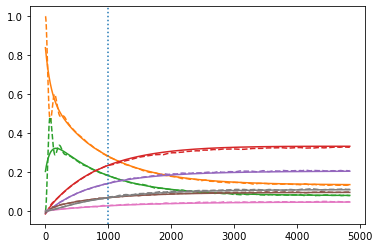

In [80]:
site_data = np.loadtxt(site_data_path)

for i, column_name in enumerate(column_names[1:], start=1):
    c = "C%i"%i
    plt.plot(site_data[:,0], site_data[:,i],"--", label=column_name, color=c)
    plt.plot(pop_full[:,0], pop_full[:,i], "-",color=c)

plt.axvline(x=1000, linestyle = ":")
plt.show()

# Retrain t1

Statistical errors in the population data can mess up the least squares fit. To work around this, we fit the population at the end of the test window after optimising the entries of the matrix $\kappa$:

In [5]:
column_names = ["Time"]
site_data_path = "../Data/mash_site300K.dat"
for i in range(1,8):
    column_names.append(str(i))
site_df = pd.read_csv(site_data_path, delimiter=" ", names=column_names)
site_df = site_df[(site_df.index % 10 == 0) | (site_df.index == len(site_df.index) - 1)]

# All the values within the df
site_eq = site_df.values 
full_time = site_df["Time"].values

t0 = 0
t1 = 500
t2 = 5000
t3 = full_time[-1]

# Only values below t2
site_df = site_df[site_df["Time"]<=t2]
start_to_t2= site_df.values #DF to NP

#EDIT THIS
start_to_t2 = start_to_t2[start_to_t2[:,0]>=t0]
t1_to_t2_full = start_to_t2[start_to_t2[:,0]>=t1]

no_states = 7
eq_pop = site_eq[-1]
eq_pop = eq_pop[1:8]

In [34]:
kappa_guess = np.full(21,0.01)
kappa = kappa_guess

save_kappas = []
save_p1s = []
save_resid1 = []
save_resid2 = []

t2s = 80*np.arange(1,51)
# t2s = 40*np.arange(1,2)
save_t = []
print(t2s)
f = open("ls_res_v2.dat",'w')
f.close()
for t2 in t2s:
    try:
        t1 = t2/2
        print(t2)
        data = site_df[site_df["Time"]<=t2]
        start_to_t2= data.values #DF to NP
        start_to_t2 = start_to_t2[start_to_t2[:,0]>=t0]
        t1_to_t2_full = start_to_t2[start_to_t2[:,0]>=t1]
        #Array of t0 to use
        start_to_t2_time = start_to_t2[:,0]
        del_t_val = start_to_t2_time[1]-start_to_t2_time[0]

        t1_to_t2_time = t1_to_t2_full[:,0]
        t1_to_t2_pop = t1_to_t2_full[:,1:]

        t0_to_t2_time = start_to_t2[:,0]
        t0_to_t2_pop = start_to_t2[:,1:]

        p_zero = start_to_t2[-1]
        p_zero = p_zero[1:8]

        #TRAIN
        time_size = len(t0_to_t2_time)
        population_data = t0_to_t2_pop[::-1]
        del_t = -del_t_val
        print("train time_size:",time_size)

        least_squares_result = least_squares(residual_kappaonly, kappa, bounds=(0,float("inf")),xtol=None, ftol=1e-8) 
        kappa_optimized = least_squares_result.x
        ls_cost = 2.*np.sqrt(least_squares_result.cost)/(time_size*no_states)
        print("LS loss:",ls_cost)
        
        f = open("ls_res_v2.dat",'a')
        f.write("%20.10f %20.10f "%(t2,ls_cost))
        
        # optimize initial population
        p1_init = population_data[0]
        least_squares_result = least_squares(residual_p1, p1_init, bounds=(0,1.),xtol=None, ftol=1e-8)
        p1_optimized = least_squares_result.x
        ls_p1_cost = 2*np.sqrt(least_squares_result.cost)/(time_size*no_states)
        print("LS (p1) loss:",ls_p1_cost)
        
        
        f.write("%20.10f "%(ls_p1_cost))
        f.write("\n")
        f.close()

        #TEST t0-t2
#         population_data = t0_to_t2_pop
#         time_size = len(population_data)
#         del_t = del_t_val
#         print("t0-t2 length: ",time_size)
#         p_zero = population_data[0,:]
#         print("p_zero eval t0-t2:",p_zero)

        #RESIDUAL CALC
#         resid1 = residual_kappaonly(kappa_optimized)
#         resid1 = np.sqrt(np.sum(resid1**2))/(time_size*no_states)
#         print("Resid 1:",resid1)

        #TEST t1-t2
        population_data = t1_to_t2_full[:,1:]
        time_size = len(t1_to_t2_full)
        del_t = del_t_val
        p_zero = population_data[0,:]
        print("t1-t2 length: ",time_size)

        #RESIDUAL CALC
        resid1 = residual_kappaonly(kappa_optimized)
        resid1 = np.sqrt(np.sum(resid1**2))/(time_size*no_states)
        print("Resid 1:",resid1)

        #TEST ALL
        t2_to_t3_full = site_eq[site_eq[:,0]>=t2]
        t2_to_t3_pop = t2_to_t3_full[:,1:]
        t2_to_t3_time = t2_to_t3_full[:,0]

        population_data = t2_to_t3_pop
        time_size = len(t2_to_t3_time)
        p_zero = population_data[0,:]
        print("t2-t3 length: ",time_size)
        
        r_of_t = matkappa_matr(kappa_optimized)
        expm_rdelt = expm(r_of_t*del_t)
        p_opt = p_model(expm_rdelt, p_zero)
            
        resid2 = residual_kappaonly(kappa_optimized)
        resid2 = np.sqrt(np.sum(resid2**2))/(time_size*no_states)
        print("Resid 2:",resid2)

        save_kappas.append(kappa_optimized)
        save_p1s.append(p1_optimized)
        save_resid1.append(resid1)
        save_resid2.append(resid2)
        
        kappa = kappa_optimized.copy()
        
        save_t.append(t2)
    except Exception as e:
        print("failed for t2=",t2)
        print(e)
        continue

[  80  160  240  320  400  480  560  640  720  800  880  960 1040 1120
 1200 1280 1360 1440 1520 1600 1680 1760 1840 1920 2000 2080 2160 2240
 2320 2400 2480 2560 2640 2720 2800 2880 2960 3040 3120 3200 3280 3360
 3440 3520 3600 3680 3760 3840 3920 4000]
80
train time_size: 17
LS loss: 0.01491797453039896
LS (p1) loss: 0.009578683985904966
t1-t2 length:  8
Resid 1: 0.006082658175301893
t2-t3 length:  984
Resid 2: 0.0018699636180034577
160
train time_size: 34
LS loss: 0.0059166480412181765
LS (p1) loss: 0.005629393306395227
t1-t2 length:  17
Resid 1: 0.0017695541345369502
t2-t3 length:  967
Resid 2: 0.00020523993359868628
240
train time_size: 50
LS loss: 0.004380976726374196
LS (p1) loss: 0.004046218952980713
t1-t2 length:  25
Resid 1: 0.0015316127334458866
t2-t3 length:  951
Resid 2: 0.00017629353596227982
320
train time_size: 67
LS loss: 0.002046472052306973
LS (p1) loss: 0.0020301173161438916
t1-t2 length:  33
Resid 1: 0.0005305197369092178
t2-t3 length:  934
Resid 2: 3.5126044594508

KeyboardInterrupt: 

In [41]:


save_t = np.array(save_t)
save_kappas = np.array(save_kappas)
save_p1s = np.array(save_p1s)
save_kappas = np.column_stack((save_t,save_kappas))
save_p1s = np.column_stack((save_t,save_p1s))
save_resid1 = np.column_stack((save_t,save_resid1))
save_resid2 = np.column_stack((save_t,save_resid2))

np.savetxt(f"scan_0_5000_optp1_resid1.dat", save_resid1, delimiter = "\t")
np.savetxt(f"scan_0_5000_optp1_resid2.dat", save_resid2, delimiter = "\t")
np.savetxt(f"scan_0_5000_optp1_kap_saved.dat",save_kappas, delimiter = "\t")
np.savetxt(f"scan_0_5000_optp1_p1_saved.dat",save_p1s, delimiter = "\t")

# Plot a certain optimization

In [40]:
print(np.array(save_t)==t2)

[False False False False False False False False False False False False
 False False False False False False False  True False False]


In [62]:
# specify the t1 you want to plot for (it's called t2 in the code)

t2 = 1520
idx = np.where(save_t==t2)[0][0]

kappa_curr = save_kappas[idx][1:]

In [63]:
column_names = ["Time"]
site_data_path = "../Data/mash_site300K.dat"
for i in range(1,8):
    column_names.append(str(i))
site_df = pd.read_csv(site_data_path, delimiter=" ", names=column_names)
site_df = site_df[(site_df.index % 10 == 0) | (site_df.index == len(site_df.index) - 1)]

# All the values within the df
site_eq = site_df.values 
full_time = site_df["Time"].values

t0 = 0
t1 = t2/2
t3 = full_time[-1]

# Only values below t2
site_df = site_df[site_df["Time"]<=t3]
start_to_t2= site_df.values #DF to NP

#EDIT THIS
start_to_t2 = start_to_t2[start_to_t2[:,0]>=t0]
t1_to_t2_full = start_to_t2[start_to_t2[:,0]>=t1]

no_states = 7
eq_pop = site_eq[-1]
eq_pop = eq_pop[1:8]

In [68]:
data = site_df[site_df["Time"]<=t2]
start_to_t2= data.values #DF to NP
start_to_t2 = start_to_t2[start_to_t2[:,0]>=t0]
t1_to_t2_full = start_to_t2[start_to_t2[:,0]>=t1]

t0_to_t2_time = start_to_t2[:,0]
t0_to_t2_pop = start_to_t2[:,1:]

t2_to_t3_full = site_eq[site_eq[:,0]>=t2]
t2_to_t3_pop = t2_to_t3_full[:,1:]
t2_to_t3_time = t2_to_t3_full[:,0]

p_zero = t0_to_t2_pop[-1]
# p_zero = save_p1s[idx][1:]

In [69]:
print(p_zero,np.sum(p_zero))

[0.21209911 0.13510281 0.2773926  0.17187976 0.07972633 0.03466734
 0.08913204] 0.9999999999993477


In [70]:
#Forwards population from t2
time_size = len(t2_to_t3_time)
r_matrix = matkappa_matr(kappa_curr) 
expm_rt = expm(r_matrix*del_t_val)
pop = p_model(expm_rt, p_zero)

#Back popualtion from t2
time_size = len(t0_to_t2_time)
expm_rt = expm(r_matrix*-del_t_val)
pop_back = p_model(expm_rt, p_zero)
pop_back = pop_back[::-1]

pop_back = np.column_stack((t0_to_t2_time,pop_back))
pop = np.column_stack((t2_to_t3_time, pop))

pop_full = np.vstack((pop_back,pop))

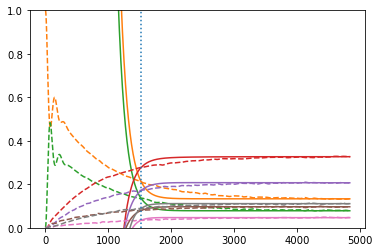

In [71]:
site_data = np.loadtxt(site_data_path)

for i, column_name in enumerate(column_names[1:], start=1):
    c = "C%i"%i
    plt.plot(site_data[:,0], site_data[:,i],"--", label=column_name, color=c)
    plt.plot(pop_full[:,0], pop_full[:,i], "-",color=c)

plt.ylim(0,1.)
plt.axvline(x=t2, linestyle = ":")
plt.show()

In [72]:
print(pop_full[:,1:].shape,np.sum(pop_full[:,1:],axis=1))

(1001, 7) [1. 1. 1. ... 1. 1. 1.]
